In [1]:
import os
os.chdir('../asr/')

In [2]:
import torch
import numpy as np
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.models import CTCModel

NOTE! Installing ujson may make loading annotations faster.


### Грузим модель и берем себе кусок данных для экспериментов

In [3]:
cfg = OmegaConf.load("./conf/conformer_ctc.yaml")


In [4]:
cfg.val_dataloader.batch_size = 100
cfg.val_dataloader.dataset.manifest_name = 'test_opus/crowd/manifest.jsonl'

In [5]:
model = CTCModel(cfg)
model.eval()
model.freeze()

ckpt = torch.load('./data/checkpoints_and_tokenizer/conformer_7epochs_state_dict.ckpt', map_location='cpu')
model.load_state_dict(ckpt)

<All keys matched successfully>

In [6]:
device = torch.device('cuda:3')

model.to(device)
model.device

device(type='cuda', index=3)

In [7]:
features_list, features_len_list = [], []
targets_list, target_len_list = [], []
logprobs_list, encoded_len_list, preds_list = [], [], []

# Отрежем себе кусок валидации для экспериментов
for i, batch in tqdm(enumerate(model.val_dataloader())):
    features, features_len, targets, target_len = batch
    with torch.inference_mode():
        logprobs, encoded_len, preds = model.forward(features.to(device), features_len.to(device))
    features_list.append(features)
    features_len_list.append(features_len)
    targets_list.append(targets)
    target_len_list.append(target_len)
    logprobs_list.append(logprobs)
    encoded_len_list.append(encoded_len)
    preds_list.append(preds)
    if i == 5:
        break

5it [00:24,  4.89s/it]


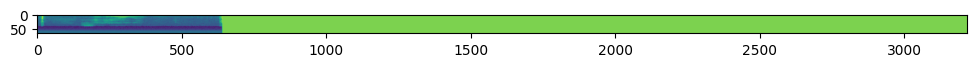

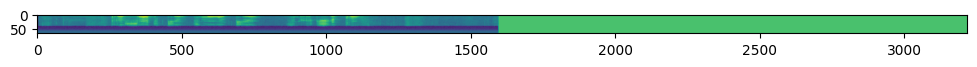

In [8]:
for feature in features[:2]:
    plt.figure(figsize=(12, 5))
    plt.imshow(feature)
    plt.show()

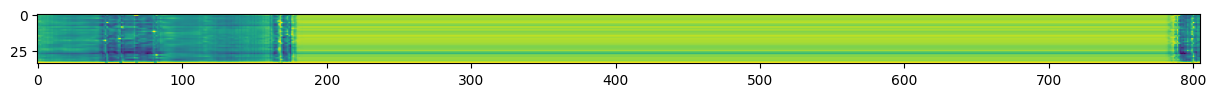

In [9]:
plt.figure(figsize=(15, 8))
plt.imshow(logprobs[0].T.cpu())
plt.show()

In [10]:
from src.metrics import WER

def calculate_greedy_wer(preds_list, encoded_len_list, targets_list):
    metric = WER()
    refs = []
    hyps = []
    for pred_batch, encoded_len_batch, targets_batch in tqdm(zip(preds_list, encoded_len_list, targets_list), total=len(preds_list)):
        for pred, pred_len, target in zip(pred_batch, encoded_len_batch, targets_batch):
            hyps.append(model.decoder.decode_hypothesis(pred[:pred_len], unique_consecutive=True))
            refs.append(model.decoder.decode_hypothesis(target, unique_consecutive=False))
    
    metric.update(refs, hyps)
    wer = metric.compute()
    return wer[0]

In [11]:
wer = calculate_greedy_wer(preds_list, encoded_len_list, targets_list)
print('WER: ', wer)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.02s/it]

WER:  tensor(0.1792)


### BeamSearch декодинг с использованием языковой модели

Будем использовать 3-Gram LM, полученную с помощью фрэймворка [KenLM](https://github.com/kpu/kenlm) и данных из датасетов [Golos](https://github.com/salute-developers/golos) и Common Crawl. Скачать модель можно из репозитория датасета Golos, по этой [ссылке](https://n-ws-3jtx8.s3pd12.sbercloud.ru/b-ws-3jtx8-eir/golos/kenlms.tar).

In [15]:
import kenlm
from torchaudio.models.decoder import ctc_decoder
import editdistance

LM_PATH = 'data/kenlms/lm_50x50.binary'
LEXICON_PATH = 'data/lexicon.txt'
lm_model = kenlm.LanguageModel(LM_PATH)

In [45]:
lm_model.score('посещающим пары студентам будет легче закрыть курс')

-32.363826751708984

In [38]:
lm_model.score('посещающим пары студентам будет сложнее закрыть курс')

-33.30598831176758

In [41]:
lm_model.score('посеающим павры студефнтам бушдет сложонее зщакрыть курс')

-44.97163009643555

In [43]:
lm_model.score('Жора - лучший лектор')

-22.83031463623047

In [36]:
lm_model.score('Жора - не лучший лектор')

-25.962114334106445

In [16]:
def calculate_wer_beamsearch(logprobs_list, encoded_len_list, targets_list, beam_search_decoder, lm_model=None):
    metric = WER()
    refs = []
    hyps = []
    best_hyps = []
    
    if lm_model is not None:
        rescored_hyps = []
    n_bests = []
    # Итерация по нашему куску даталоадера
    for logprob_batch, encoded_len_batch, targets_batch in tqdm(zip(logprobs_list, encoded_len_list, targets_list), total=len(logprobs_list)):
        beamsearch_result = beam_search_decoder(logprob_batch.cpu(), encoded_len_batch.cpu())
        
        # Итерация по батчу
        for i in range(len(beamsearch_result)):
            ref = model.decoder.decode_hypothesis(targets_batch[i], unique_consecutive=False)
            refs.append(ref)
            
            # Итерация по n-best списку
            best_distance = 10000
            best_hyp = None
            
            if lm_model is not None:
                best_rescored_hyp = None
                best_score = -100000
                
            n_bests.append([])
            for j in range(len(beamsearch_result[i])):
                curr_tokens = beamsearch_result[i][j].tokens
                curr_hyp = model.decoder.decode(curr_tokens.unsqueeze(0), [len(curr_tokens)])[0]
                n_bests[-1].append({'hyp': curr_hyp, 'score':beamsearch_result[i][j].score})
                
                if j == 0:
                    hyps.append(curr_hyp)
                
                distance = editdistance.eval(ref.split(), curr_hyp.split())
                if distance < best_distance:
                    best_hyp = curr_hyp
                    best_distance = distance
                
                if lm_model is not None:
                    score = lm_model.score(curr_hyp)
                    if score > best_score:
                        best_score = score
                        best_rescored_hyp = curr_hyp
                    
            best_hyps.append(best_hyp)
            
            if lm_model is not None:
                rescored_hyps.append(best_rescored_hyp)
    
    metric.update(refs, hyps)
    wer = metric.compute()
    
    metric.reset()
    metric.update(refs, best_hyps)
    oracle_wer = metric.compute()
    
    output = {
        'wer': wer[0],
        'oracle_wer': oracle_wer[0],
        'references': refs,
        'hypotheses': hyps,
        'oracle_hypotheses': best_hyps,
        'n_bests': n_bests
    }
    
    if lm_model is not None:      
        metric.reset()
        metric.update(refs, rescored_hyps)
        rescored_wer = metric.compute()
        output.update({
            'rescored_wer': rescored_wer[0],
            'rescored_hypotheses': rescored_hyps,
        })
    
    return output

In [17]:
from torchaudio.models.decoder import ctc_decoder


TOKENS = cfg.model.labels + ['|']

LM_WEIGHT = 3.23
WORD_SCORE = -0.26

beam_search_decoder = ctc_decoder(
    lexicon='data/lexicon.txt',
    tokens=TOKENS,
    nbest=5,
    beam_size=50,
    sil_token=' ',
    blank_token='|',
    lm='data/kenlms/lm_50x50.binary',
    lm_weight=LM_WEIGHT,
    word_score=WORD_SCORE,
)

output = calculate_wer_beamsearch(logprobs_list, encoded_len_list, targets_list, beam_search_decoder)
n_bests = output['n_bests']
refs = output['references']

print('WER: ', output['wer'])
print('Oracle WER: ', output['oracle_wer'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:19<00:00,  3.24s/it]

WER:  tensor(0.1099)
Oracle WER:  tensor(0.0861)


In [18]:
BEAM_SIZES = [5, 10, 20, 50]
wer_results = []
oracle_wer_results = []
rescored_wer_results = []

for beam_size in BEAM_SIZES:
    beam_search_decoder = ctc_decoder(
        lexicon='data/lexicon.txt',
        tokens=TOKENS,
        nbest=beam_size,
        beam_size=beam_size,
        sil_token=' ',
        blank_token='|',
        lm='data/kenlms/lm_50x50.binary',
        lm_weight=LM_WEIGHT,
        word_score=WORD_SCORE,    
    )
    output = calculate_wer_beamsearch(logprobs_list, encoded_len_list, targets_list, beam_search_decoder)
    wer_results.append(output['wer'])
    oracle_wer_results.append(output['oracle_wer'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.69s/it]


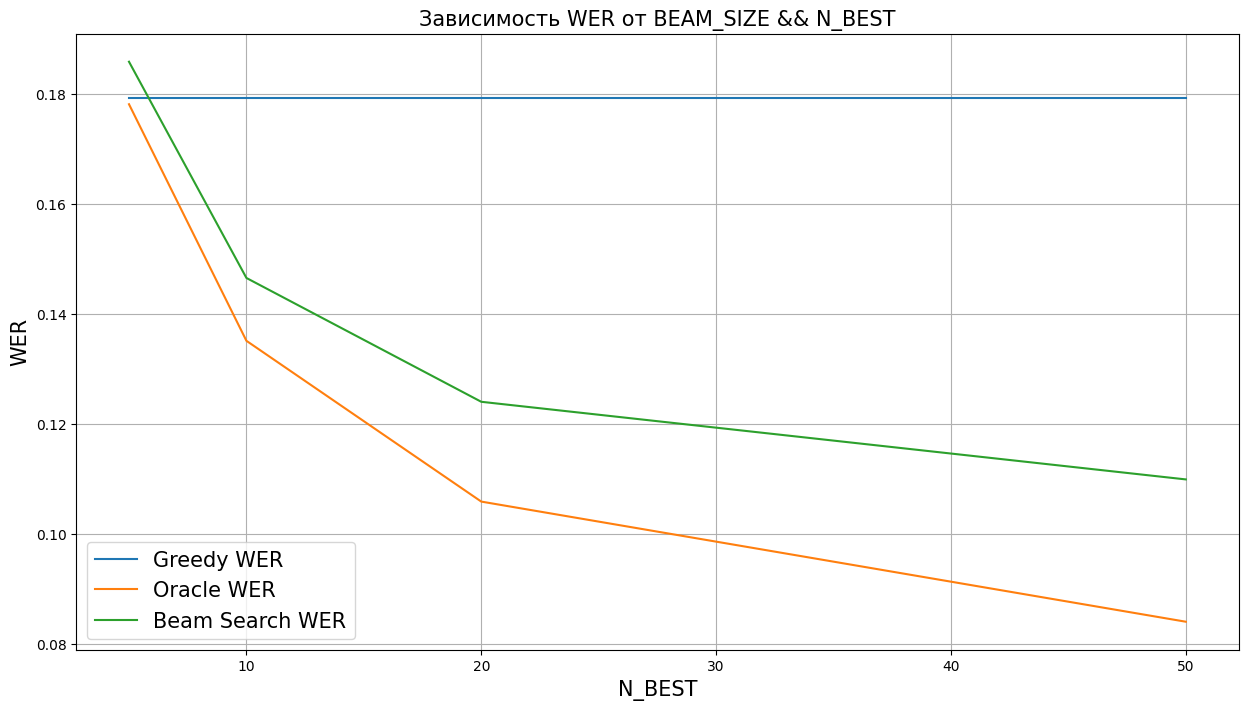

In [19]:
plt.figure(figsize=(15, 8))
plt.plot(BEAM_SIZES, [0.1792] * 4, label='Greedy WER')
plt.plot(BEAM_SIZES, oracle_wer_results, label='Oracle WER')
plt.plot(BEAM_SIZES, wer_results, label='Beam Search WER')
plt.ylabel('WER', fontsize=15)
plt.xlabel('N_BEST', fontsize=15)
plt.title('Зависимость WER от BEAM_SIZE && N_BEST', fontsize=15)
plt.legend(fontsize=15)
plt.grid()

### Рескоринг
Теперь вместо интеграции языковой модели в beam-search будем использовать ее для рескоринга гипотез.

In [20]:
TOKENS = cfg.model.labels + ['|']

beam_search_decoder = ctc_decoder(
    lexicon=None,
    tokens=TOKENS,
    nbest=5,
    beam_size=50,
    sil_token=' ',
    blank_token='|',
)
output = calculate_wer_beamsearch(logprobs_list, encoded_len_list, targets_list, beam_search_decoder, lm_model)
n_bests = output['n_bests']
refs = output['references']

print('WER: ', output['wer'])
print('Oracle WER: ', output['oracle_wer'])
print('Rescored WER: ', output['rescored_wer'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:29<00:00,  4.99s/it]

WER:  tensor(0.1792)
Oracle WER:  tensor(0.1254)
Rescored WER:  tensor(0.1590)


In [47]:
def print_nbest_with_scores(n_bests, ref):
    wers = [editdistance.eval(ref.split(), n_best['hyp'].split()) / len(ref.split()) for n_best in n_bests]
    scores = [lm_model.score(n_best['hyp']) for n_best in n_bests]
    print('REFERENCE:')
    print(f'{ref.strip()} | SCORE = {lm_model.score(ref)}')
    print('-'*50)
    print('N_BEST LIST:')
    oracle_index = np.argmin(wers)
    rescored_index = np.argmax(scores)
    for i in range(len(wers)):
        additional = '| **ORACLE HYP** ' if oracle_index == i else ''
        additional += '| **RESCORED HYP**' if rescored_index == i else ''
        hyp = n_bests[i]['hyp'].strip()
        am_score = n_bests[i]['score']
        print(f'{i}: {hyp}  {additional}\nWER = {wers[i]} | ACOUSTIC_SCORE: {am_score} | LM_SCORE = {scores[i]}')
        print()

In [48]:
index = np.random.randint(500)
print_nbest_with_scores(n_bests[index], refs[index])

REFERENCE:
салют вызови контакт | SCORE = -7.2406816482543945
--------------------------------------------------
N_BEST LIST:
0: салют вызови контакит  
WER = 0.3333333333333333 | ACOUSTIC_SCORE: -4.369964790863833 | LM_SCORE = -13.085274696350098

1: салют вызови контакт  | **ORACLE HYP** | **RESCORED HYP**
WER = 0.0 | ACOUSTIC_SCORE: -5.163354111237368 | LM_SCORE = -7.2406816482543945

2: салют вызови конпакит  
WER = 0.3333333333333333 | ACOUSTIC_SCORE: -5.6878730779121724 | LM_SCORE = -13.085274696350098

3: салют вызови контакьт  
WER = 0.3333333333333333 | ACOUSTIC_SCORE: -6.120433044953188 | LM_SCORE = -13.085274696350098

4: салют вызови конпакт  
WER = 0.3333333333333333 | ACOUSTIC_SCORE: -6.481262398285708 | LM_SCORE = -13.085274696350098



In [23]:
N_BESTS = [2, 5, 10, 20, 50]
wer_results = []
oracle_wer_results = []
rescored_wer_results = []

for n_best in N_BESTS:
    beam_search_decoder = ctc_decoder(
        lexicon=None,
        tokens=TOKENS,
        nbest=n_best,
        beam_size=n_best,
        sil_token=' ',
        blank_token='|',
    )
    output = calculate_wer_beamsearch(logprobs_list, encoded_len_list, targets_list, beam_search_decoder, lm_model)
    wer_results.append(output['wer'])
    oracle_wer_results.append(output['oracle_wer'])
    rescored_wer_results.append(output['rescored_wer'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:45<00:00,  7.58s/it]


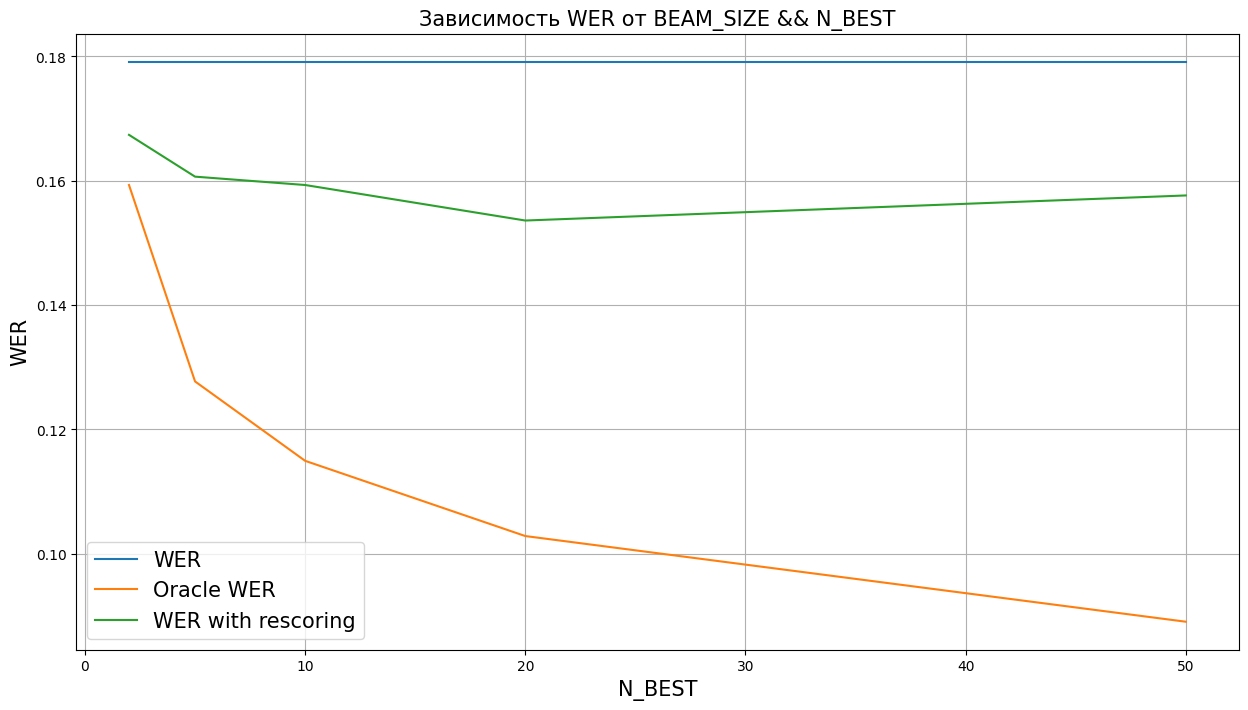

In [25]:
plt.figure(figsize=(15, 8))
plt.plot(N_BESTS, wer_results, label='WER')
plt.plot(N_BESTS, oracle_wer_results, label='Oracle WER')
plt.plot(N_BESTS, rescored_wer_results, label='WER with rescoring')

plt.ylabel('WER', fontsize=15)
plt.xlabel('N_BEST', fontsize=15)
plt.title('Зависимость WER от BEAM_SIZE && N_BEST', fontsize=15)
plt.legend(fontsize=15)
plt.grid()